In [194]:
import pandas as pd
import pandas_datareader.data as pdr
from datetime import date
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [195]:
yf.pdr_override()

In [196]:
tickers = ['GOOG','AMZN','MSFT','AAPL']
data_source = 'yahoo'

In [197]:
start_date = date(2020, 1, 1)
end_date = date(2023, 1, 1)

In [198]:
stock_prices = pdr.get_data_yahoo(tickers=tickers, start=start_date, end=end_date)
stock_prices = stock_prices.stack()

[*********************100%***********************]  4 of 4 completed


In [199]:
data = stock_prices['Close'].unstack()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2020-01-02 to 2022-12-30
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    756 non-null    float64
 1   AMZN    756 non-null    float64
 2   GOOG    756 non-null    float64
 3   MSFT    756 non-null    float64
dtypes: float64(4)
memory usage: 29.5 KB


In [200]:
daily_returns = data.pct_change()
weights = np.array([0.05, 0.4, 0.3, 0.25])

In [201]:
# Calculate the covariance matrix on daily returns
# Note: 250 = 250 trading days in a year
cov_matrix = (daily_returns.cov())*250
print(cov_matrix)

          AAPL      AMZN      GOOG      MSFT
AAPL  0.135354  0.094914  0.091602  0.103363
AMZN  0.094914  0.151546  0.091062  0.094593
GOOG  0.091602  0.091062  0.117196  0.097821
MSFT  0.103363  0.094593  0.097821  0.119950


In [202]:
# Calculate the standard deviation by taking the square root
port_standard_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
print(str(np.round(port_standard_dev, 4) * 100) + '%')

32.74%


In [203]:
print(cov_matrix)

          AAPL      AMZN      GOOG      MSFT
AAPL  0.135354  0.094914  0.091602  0.103363
AMZN  0.094914  0.151546  0.091062  0.094593
GOOG  0.091602  0.091062  0.117196  0.097821
MSFT  0.103363  0.094593  0.097821  0.119950


## Comparing returns

1. *Annual Return*: Total return earned over a period of one calendar year
2. *Annualized return*: Yearly rate of return inferred from any time period
3. *Average Return*:  Total return realized over a longer period, spread out evenly over the (shorter) periods.
4. *Cumulative (compounding) return*: A return that includes the compounded results of re-investing, dividends, and capital gains.

### Calculating annualized returns

- **N in years**: rate = (1 + Return) ^ 1/N - 1
- **N in months**: rate = (1 + Return) ^ 12/N - 1
- Convert any time length to an annual rate
- **Return** is total return you want to annualize
- **N** is number of periods so far.

### Annualized returns in python

In [204]:
apple_price = data['AAPL']

apple_price.head(1)

Date
2020-01-02    75.087502
Name: AAPL, dtype: float64

In [205]:
apple_price.tail(1)

Date
2022-12-30    129.929993
Name: AAPL, dtype: float64

In [206]:
months = 24

In [207]:
# Calculate the total return
total_return = (apple_price[-1] - apple_price[0]) / apple_price[0]

print(total_return)

0.7303810892016547


In [208]:
annualized_return = ((1 + total_return)**(12/months)) - 1

print(annualized_return)

0.3154395041968501


In [209]:
for col in data.columns:
    total_return = (data[col].iloc[-1]  - data[col].iloc[0]) / data[col].iloc[0]
    annualized_return = ((1 + total_return)**(12/months)) -1
    print(col, annualized_return)

AAPL 0.3154395041968501
AMZN -0.059182474978833666
GOOG 0.13921901150546678
MSFT 0.2219203615755656


## Risk adjusted returns

### Choose a portfolio ?
**Portfolio 1**
- Annual return of 14%
- Volatility (standard deviation) is 8%

**Portfolio 2**
- Annual return of 6%
- Volatility is 3%

### About risk adjusted return
- It defines an investment's return by measuring how much risk is involved in producting that return
- It's usually a ratio
- Allows you to objectively compare across different investment options
- Tells you whether the return justifies the underlying risk

### Sharpe ratio
- Sharpe ratio is the most commonly used risk adjusted return ratio
- It's calculated as follows
- ***Sharpe ratio*** = (Rp - Rf) / Op
- Where: *Rp* is the portfolio return, *Rf* is the risk free rate and *Op* is the portfolio standard deviation
- ***Op*** = sqrt(Weights.T * (Covariance matrix * Weights))

### Annualizing volatility
- Annualized standard deviation is calculated as follows: Oa = Om * sqrt(T)
- Om is the measured standard deviation
- Oa is annualized standard deviation
- T is the number of data points per year (250)

### Calculating the Sharpe Ratio

In [210]:
apple_returns = apple_price.pct_change()

In [211]:
annualized_vol = apple_returns.std() * np.sqrt(250)
print(annualized_vol)

0.36790542445787827


In [212]:
risk_free = 0.01

In [213]:
total_return = (apple_price[-1]  - apple_price[0]) / apple_price[0]
annualized_return = ((1 + total_return)**(12/months)) - 1
print(annualized_return)

0.3154395041968501


In [214]:
sharpe_ratio = (annualized_return - risk_free) / annualized_vol
print(sharpe_ratio)

0.8302120161640074


## Non-normal distribution of returns

### Pearson's Coefficient of Skewness

***Skewness*** = 3 * (mean - median) / (standard deviation)

Rule of thumb:
- *Skewnesss* < -1 or *Skewness > 1 -> Highly skewed distribution
- -1 < *Skewness* < -0.5 or 0.5 < *Skewness* < 1 -> Moderately skewed distribution
- -0.5 < *Skewness* < 0.5 -> Approximately symmetric distribution

### Kurtosis: Fat tailed distribution
### Interpreting kurtosis
*"Higher kurtosis means more of the variance is the result of infrequent extreme deviations, as opposed to frequent modestly deviations"*

- A normal distribution has kurtosis of exactly 3 and is called (mesokurtic)
- A distribution with kurtosis <3 is called platykurtic. Tails are shorter and thinner, and central peak is lower and broader
- A distribution with kurtosis >3 is called leptokurtic. Tails are longer and fatter, and central peak is higher and sharper **(fat tailed)**

### Calculating skewness and kurtosis

In [215]:
apple_returns.head(3)

Date
2020-01-02         NaN
2020-01-03   -0.009722
2020-01-06    0.007968
Name: AAPL, dtype: float64

<Axes: >

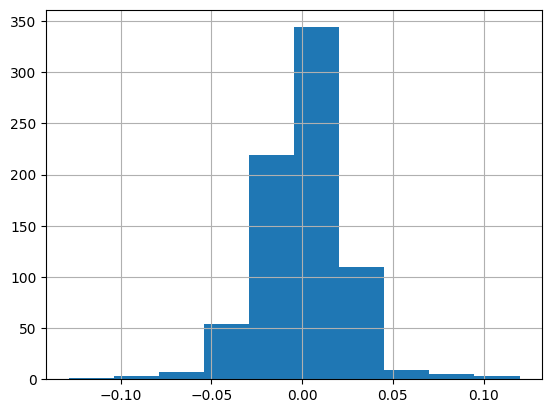

In [216]:
apple_returns.hist()

In [217]:
print("mean : ", apple_returns.mean())
print("vol : ", apple_returns.std())
print("skew : ", apple_returns.skew())
print("kurt : ", apple_returns.kurtosis())

mean :  0.0009966930451517286
vol :  0.023268382096358276
skew :  0.09752757534172643
kurt :  4.037640152069237


## Alternative measures of risk

### Looking at downside risk
![Downside risk](../assets/images/downside_risk.png)

- A good risk measure should focus on potential losses i.e. downside risk

### Sortino ratio
- Similar to the Sharpe ratio, just with a different standard deviation
- *Sortino Ratio* = (Rp - Rf) / (standard deviation of the downside)
- Downside risk fomula:

![Downside risk](../assets/images/downside_risk_fomula.png)

### Sortino ratio in python

In [218]:
rfr = 0
target_return = 0

In [219]:
negative_returns = apple_returns.loc[apple_returns < target_return]

In [220]:
negative_returns.head(3)

Date
2020-01-03   -0.009722
2020-01-07   -0.004703
2020-01-14   -0.013503
Name: AAPL, dtype: float64

In [221]:
expected_return = apple_returns.mean()
down_stdev = negative_returns.std()

In [222]:
sortino_ratio = (expected_return - rfr) / down_stdev
print(sortino_ratio)

0.06223606041824739


### Maximun draw-down
- The largest percentage loss from a market peak to trough (valley)
- Dependent on the chosen time window
- The recovery time: time it takes to get back to break-even
### Maximum daily draw-down in Python

In [223]:
roll_max = apple_price.rolling(min_periods=1, window=250).max()
print(roll_max)

Date
2020-01-02     75.087502
2020-01-03     75.087502
2020-01-06     75.087502
2020-01-07     75.087502
2020-01-08     75.797501
                 ...    
2022-12-23    182.009995
2022-12-27    182.009995
2022-12-28    182.009995
2022-12-29    182.009995
2022-12-30    179.699997
Name: AAPL, Length: 756, dtype: float64


In [224]:
daily_drawdown = apple_price/roll_max - 1.0

In [225]:
max_daily_drawdown = daily_drawdown.rolling(min_periods=1, window=250).min()

<Axes: xlabel='Date'>

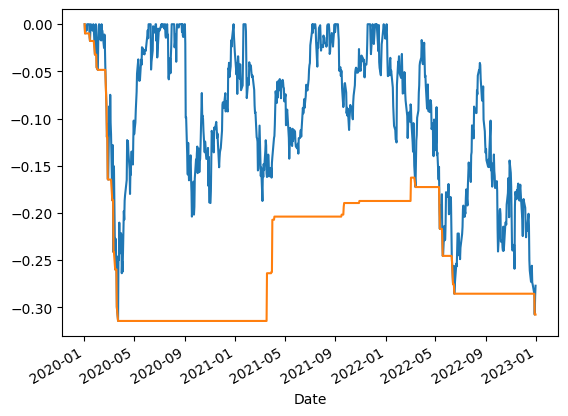

In [226]:
daily_drawdown.plot()
max_daily_drawdown.plot()

# Performance Attribution
In chapter 3, you’ll learn about investment factors and how they play a role in driving risk and return. You’ll learn about the Fama French factor model, and use that to break down portfolio returns into explainable, common factors. This chapter also covers how to use Pyfolio, a public portfolio analysis tool.

## Comparing against a benchmark

### Active investing against a benchmark
![Active investing vs SP500](../assets/images/active_investing.png "Vanguard vs SP500")
### Active return for an actively managed portfolio
- Active return is the performance of an (active) investment, relative to the investment's benchmark
- Calculated as the **difference between the benchmark and the actual return**
- Active return is achieved by "active" investing, i.e. taking **overweight and underweight positions** from the benchmark
### Tracking error for an index tracker
- Passive investment funds, or **index trackers**, don't use active return as a measure for performance
- **Tracking error** is the name used for the difference in portfolio and benchmark for a passive investment fund.
### Active weights
![Active weights](../assets/images/acitve_weights.png "Active weights of portfolio and SP500 Index")

### Active return in Python

In [227]:
portfolio_data = pd.read_csv('../datasets/large_pf.csv', index_col=0)
portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, A to ZTS
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mean_return        501 non-null    float64
 1   variance           501 non-null    float64
 2   pf_weights         501 non-null    float64
 3   bm_weights         501 non-null    float64
 4   Security           501 non-null    object 
 5   GICS Sector        501 non-null    object 
 6   GICS Sub Industry  501 non-null    object 
dtypes: float64(4), object(3)
memory usage: 31.3+ KB


In [228]:
# Check the portfolio weights
print(portfolio_data['pf_weights'].sum())

100.0


In [229]:
# Calculate return of the portfolio
total_return_pf = (portfolio_data['mean_return']*portfolio_data['pf_weights']).sum()
print(total_return_pf)

33.134025872593554


In [230]:
# Calculate return of the benchmark
total_return_bm = (portfolio_data['mean_return']*portfolio_data['bm_weights']).sum()
print(total_return_bm)

10.557642112692943


In [231]:
# Calculate and print the active return
active_return = total_return_pf - total_return_bm
print ("%.2f%%" % active_return)

22.58%


In [232]:
# Group dataframe by GICS sectors
grouped_df = portfolio_data.groupby('GICS Sector').sum()
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, Consumer Discretionary to Utilities
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mean_return        11 non-null     float64
 1   variance           11 non-null     float64
 2   pf_weights         11 non-null     float64
 3   bm_weights         11 non-null     float64
 4   Security           11 non-null     object 
 5   GICS Sub Industry  11 non-null     object 
dtypes: float64(4), object(2)
memory usage: 616.0+ bytes


In [233]:
grouped_df.head()

,mean_return,variance,pf_weights,bm_weights,Security,GICS Sub Industry
GICS Sector,,,,,,
Consumer Discretionary,14.091950,3.011996,32.426,12.169,Advance Auto PartsAmazon.com IncAutoNation Inc...,Automotive RetailInternet & Direct Marketing R...
Consumer Staples,5.131286,0.639845,24.551,29.727,Archer-Daniels-Midland CoConAgra Foods Inc.Chu...,Agricultural ProductsPackaged Foods & MeatsHou...
Energy,3.390600,1.897641,0.000,0.000,Apache CorporationAnadarko Petroleum CorpBaker...,Oil & Gas Exploration & ProductionOil & Gas Ex...
Financials,8.701437,1.879873,0.000,2.116,"AFLAC IncAmerican International Group, Inc.Ass...",Life & Health InsuranceProperty & Casualty Ins...
Health Care,10.747583,2.349866,11.964,9.099,Agilent Technologies IncAbbVieAmerisourceBerge...,Health Care EquipmentPharmaceuticalsHealth Car...


In [234]:
grouped_df['active_weight'] = grouped_df['pf_weights'] - grouped_df['bm_weights']
print(grouped_df['active_weight'])

GICS Sector
Consumer Discretionary         20.257
Consumer Staples               -5.176
Energy                          0.000
Financials                     -2.116
Health Care                     2.865
Industrials                     2.465
Information Technology          8.693
Materials                      -2.043
Real Estate                     2.014
Telecommunications Services    -1.367
Utilities                     -25.593
Name: active_weight, dtype: float64


## Risk factors
### What is a factor?
Factors in portfolios are like nutrients in food
![Portfolio factors](../assets/images/portfolio_factor.png "Portfolio factors")
### Factors in portfolios
Different types of factors
- Macro factors: interest rates, currency, country, industry
- Style factors: momentum, volatility, value and quality
![Style factors](../assets/images/style_factors.png "Style factors")
### Using factor models to determine risk exposure
![Factor investing](../assets/images/factor_investing.png "Factor investing")
### Factor exposures

#### Size factor

#### Momemtum factor
A stock is showing "momentum" if its prior 12-month average of returns is positive. The momentum factor is therefore formed by combining stocks that show consistent positive historic returns. 
#### Value factor
The value factor looks at stocks that are inexpensive relative to some measure of fundamental value. For example price-to-earnings and price-to-book are typically ratios to measure "value".

In [235]:
pf_factors = pd.read_csv('../datasets/pf_factors.csv', parse_dates=['date'], index_col='date')
pf_factors.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2016-01-04 to 2016-12-30
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   S&P500        252 non-null    float64
 1   WML           252 non-null    float64
 2   value_factor  252 non-null    float64
 3   portfolio     252 non-null    float64
dtypes: float64(4)
memory usage: 9.8 KB


In [236]:
pf_factors['momentum'] = pf_factors['WML']

In [237]:
# Calculate 20-day rolling correlation with momentum 
pf_factors['correlation_mom'] = pf_factors['S&P500'].rolling(20).corr(pf_factors['momentum'])

# Calculate 20-day rolling correlation with value
pf_factors['correlation_value'] = pf_factors['S&P500'].rolling(20).corr(pf_factors['value_factor'])

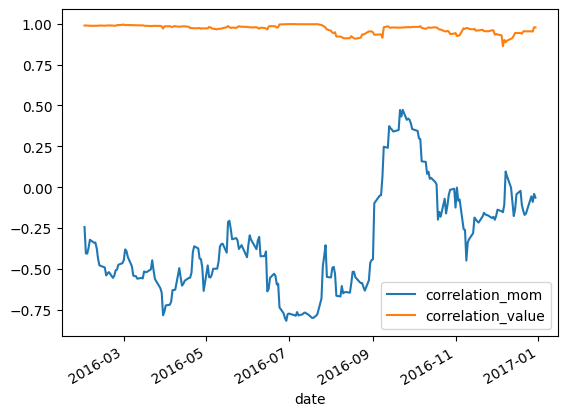

In [238]:
# Plot the correlations
pf_factors['correlation_mom'].plot()
pf_factors['correlation_value'].plot()
plt.legend()

In [239]:
factor_data = pf_factors.loc[:,['momentum', 'value_factor', 'portfolio']]
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2016-01-04 to 2016-12-30
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   momentum      252 non-null    float64
 1   value_factor  252 non-null    float64
 2   portfolio     252 non-null    float64
dtypes: float64(3)
memory usage: 7.9 KB


In [240]:
factor_data.corr()

,momentum,value_factor,portfolio
momentum,1.000000,-0.363237,0.001012
value_factor,-0.363237,1.000000,0.767663
portfolio,0.001012,0.767663,1.000000


In [241]:
factor_data['correlation_value'] = factor_data['portfolio'].rolling(5).corr(factor_data['value_factor'])

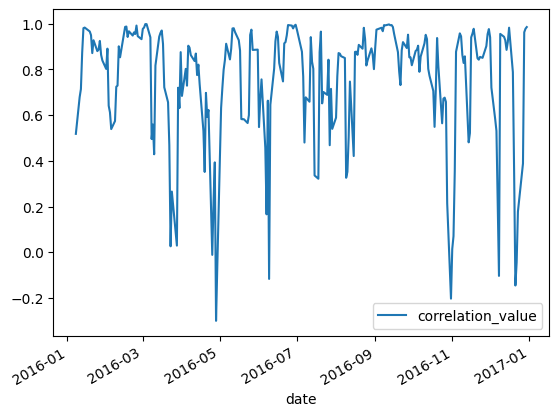

In [242]:
factor_data['correlation_value'].plot()
plt.legend()